In [116]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import keras
import cv2

In [25]:
import progressbar
from time import sleep

ImportError: No module named 'progressbar'

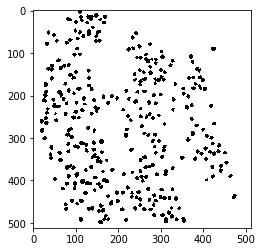

255 1


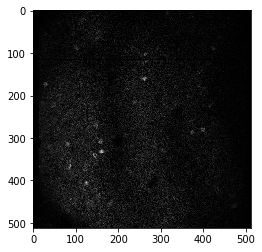

224 0


In [117]:
import cv2
frame_no = 499
cap = cv2.VideoCapture('Databinary/substack500_7fps_00.label.tif') #video_name is the video being called
cap.set(1,frame_no); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
plt.imshow(frame)
plt.show()
print(frame.max(), frame.min())
cap = cv2.VideoCapture('Databinary/substack500_7fps_00.avi') #video_name is the video being called
cap.set(1,frame_no); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
plt.imshow(frame)
plt.show()
print(frame.max(), frame.min())

The input images thus need to be normalised because values are not within the range of 0 and 1. This will hopefully help the network to optimise better

DEFINE MODEL AND TRAINING PROCEDURE

In [199]:
from keras.models import Model
from keras.layers.convolutional import Conv3D, Conv2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, TimeDistributed
import keras.backend as K
import tensorflow as tf

from keras.layers import (ConvLSTM2D, BatchNormalization, Convolution3D, Convolution2D,Conv2D,
                          TimeDistributed, MaxPooling2D, UpSampling2D, Input, merge, Cropping2D, concatenate)


K.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0})))

def load_model(batch_size,true_frag_len):
    input_shape = (None, 256, 400, 1)
    input = Input(batch_shape= [batch_size, true_frag_len, 256,400, 1])
    
    x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(input)
    x = TimeDistributed(MaxPooling2D((2, 2), (2, 2)))(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(filters=14, kernel_size=(3, 3),
                       input_shape=input_shape,
                       padding='same', 
                       return_sequences=True,
                       stateful = True)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(x)
    
    upsl_1 = TimeDistributed(UpSampling2D((2, 2)))(x)
    output = TimeDistributed(Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='softmax'), name='output')(upsl_1)
    # output = Conv3D(filters=1, kernel_size=(3, 3, 3),
    #                    activation='sigmoid',
    #                    padding='same', data_format='channels_last')(x)


    model_stateful_batch = Model(inputs = [input], output=[output])
    model_stateful_batch.compile(loss='binary_crossentropy', optimizer='adadelta')
    model_stateful_batch.summary()
    return model_stateful_batch

In [187]:
def train_model(model, no_samples, no_frags, generator,valid_generator,epochs, frag_len):
    
    for epoch in range(epochs):
        print("Number of training reps " + str(no_samples))
        for reps in range(reps_for_samples):
            if reps%(no_frags) == 0:
                print ('Time to reset states')
                model.reset_states()
            train_loss = 0
            X,Y = next(generator.generate())
            train_loss += model.train_on_batch(X, Y)
            #print ('# epoch', reps, '  loss ', train_loss/float(Y.shape[0]))
            #if reps%no_frags == 0:
            if reps%50 == 0:
                print ('# Iteration', reps, '  loss ', train_loss/float(Y.shape[0]))
                print(train_loss)
        print ('# Epoch', epoch + 1, '  loss ', train_loss/float(Y.shape[0]))
        model.reset_states()
        print("Done training")
        print("Traing loss " + str(train_loss))
        print("Validating")
        validate(model,no_frags, frag_len)
    return model

In [188]:
def validate(model, no_frags, frag_len):
    ypred = batch_prediction(model, valid_generator, no_frags)
    # this frag len is not defined so we need a way to get it in here
    print("Remember frag len here is probbaly wrong")
    ytrue = ytrue_for_validation()/255
    ypred = ypred[no_frags-1][0][frag_len-1]
    print(ytrue.max(), ytrue.min())
    print(ypred.max(), ypred.min())
    print(ytrue.reshape(256,400).shape)
    print(ypred.reshape(256,400).shape)
    the_metric = nf_mask_metrics(ypred.reshape(256,400), ytrue.reshape(256,400))
    print(the_metric)

In [189]:
def ytrue_for_validation():
    vect = cv2.VideoCapture("Databinary/substack500_7fps_10.label.tif")
    vect.set(1,1)
    ret,lab_frame = vect.read()
    lab_frame = cv2.resize(lab_frame,(400,256))
    lab_frame = cv2.cvtColor(lab_frame, cv2.COLOR_BGR2GRAY)
    return lab_frame

In [190]:
def batch_prediction(model, generator, no_frags):
# this just tests out one sample. I think it is necessary to reset states on prediction too
    stateful_preds = []
    model.reset_states()
    gen = generator.generate()
    for fragment in range(no_frags):
        X,Y = next(gen)
        stateful_batch = model.predict_on_batch(X)
        stateful_preds.append(stateful_batch)
    return stateful_preds

In [191]:
from skimage import measure
from regional import many
from neurofinder import centers, shapes
def _mask_to_regional(m):
    """Convert a 2D numpy mask to a regional many object so it can be measured
    using the neurofinder library."""
    mlbl = measure.label(m)
    coords = []
    for lbl in range(1, np.max(mlbl) + 1):
        yy, xx = np.where(mlbl == lbl)
        coords.append([[y, x] for y, x in zip(yy, xx)])
    return many(coords)

In [192]:
def nf_mask_metrics(m, mp):
    """Computes precision, recall, inclusion, exclusion, and combined (F1) score for the given mask (m) and predicted mask (mp). Note that this does assumes single 2D masks and does not aaccount for overlapping neurons.

    # Arguments
        m: ground-truth (height x width) binary numpy mask.
        mp: predicted (height x width) binary numpy mask.

    # Returns
        p,r,i,e,f1: precision, recall, inclusion, exclusion, and F1 scores.

    """
    # Return all zeros if the predicted mask is empty.
    if np.sum(mp.round()) == 0:
        return 0., 0., 0., 0., 0.

    # Convert masks to regional format and compute their metrics.
    m = _mask_to_regional(m)
    mp = _mask_to_regional(mp)
    r, p = centers(m, mp)
    i, e = shapes(m, mp)
    f1 = 2. * (r * p) / (r + p)
    return (p, r, i, e, f1)

In [193]:
ypred_test = ytrue_for_validation()
ytrue_test = ytrue_for_validation()
nf_mask_metrics(ypred_test.reshape(256,400),ytrue_test.reshape(256,400))

(1.0, 1.0, 1.0, 1.0, 1.0)

## STOCHASTIC
## STATEFUL batch_shape = [1, frag_len, x, y, 1]
    1 sample at a time
    update made after no_fragments batches
    y = [1, 1, x, y, 1]

DEFINE DATA FEEDER

There are two ways to sample the data as illustrated below. Check it out. The only difference is how indexes are defined for data range of each fragment and then the no of resulting fragments.

no of fragments and length of fragments changes with the step size so the real length becomes (frag_len+1)/steps and number of fragments is (data_len-frag_len + 1)/steps

In [26]:
example = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22]
data_len = len(example)
frag_len = 11
steps = 2
no_frags = int((data_len-frag_len + 1)/steps)
print(no_frags)

for current_count in range(no_frags):
    #ranger = list(range(current_count,current_count+ frag_len))
    indx = np.arange(current_count*steps,current_count*steps+ frag_len, steps)
    print(np.array(example)[indx.astype(int)])
(np.array(example)[indx.astype(int)]).shape

6
[ 1  3  5  7  9 11]
[ 3  5  7  9 11 13]
[ 5  7  9 11 13 15]
[ 7  9 11 13 15 17]
[ 9 11 13 15 17 19]
[11 13 15 17 19 21]


(6,)

no of fragments does not change with the step size but, the actual length of the fragment is changed by the step size. so the real length becomes (frag_len+1)/steps 

In [27]:
example = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22]
data_len = len(example)
frag_len = 11
steps = 2
no_frags = int(data_len-frag_len + 1)
print(no_frags)

for current_count in range(no_frags):
    #ranger = list(range(current_count,current_count+ frag_len))
    indx = np.arange(current_count,current_count+ frag_len, steps)
    print(np.array(example)[indx.astype(int)])
(np.array(example)[indx.astype(int)])

12
[ 1  3  5  7  9 11]
[ 2  4  6  8 10 12]
[ 3  5  7  9 11 13]
[ 4  6  8 10 12 14]
[ 5  7  9 11 13 15]
[ 6  8 10 12 14 16]
[ 7  9 11 13 15 17]
[ 8 10 12 14 16 18]
[ 9 11 13 15 17 19]
[10 12 14 16 18 20]
[11 13 15 17 19 21]
[12 14 16 18 20 22]


array([12, 14, 16, 18, 20, 22])

Quick check to make sure the data is loaded correctly by the data generator. Also a quick check to make sure the images returned are nomalised (value range between 0 and 1). 

NB. Make sure current sample number of next output block is the same as the label vect that is read by cv2 when drawing otherwise images wont match and you might think it is not working

In [142]:
class Batch_size_1_Generator(object):

    def __init__(self, frag_len, steps = 1, valid = False):
        self.frag_len = frag_len
        #print(frag_len)
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        self.current_count = 0
        self.data = None
        # dimensions expected by the network
        self.dims = (400,256)
        self.steps = steps
        self.valid = valid
    
        #self.dup_rows()
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set

    def dup_rows(self, a, indx, num_dups=1):
        return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)
    
    def _resizeNnormalize(self, data, dimso):
        """
        data : the image to be resized 
        dimso : the dimensions to be resized to (tuple)
        """
        data = cv2.resize(data, dimso)
        img = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
        nomalized = img/255
        return nomalized
    
    
    def generate(self):
        # this generator returns no_frag fragments for each sample before moving to the next sample
        while True:
            if self.valid == True:
                self.current_idx = '10'
                if self.current_count == 0:
                    print('Validating')
            elif self.current_count == 0:
                self.current_idx = '0' + str(np.random.randint(10))
            video = cv2.VideoCapture('Databinary/substack500_7fps_' + self.current_idx + '.avi')

            data_len = 50
            # find out number of fragments for data
            no_frags = int((data_len-self.frag_len + 1)/self.steps)
            #no_frags = int(data_len/frag_len)
            
            #print("No frags inside " + str(no_frags))
            self.current_count += 1
            #print('current sample number: ' + str(self.current_idx)+', Fragment ' + str(self.current_count)+ ' of ' + str(no_frags))
            
            if self.current_count == no_frags:
                #print(self.current_count)
                self.current_count = 0
            data_range = (self.current_count,self.current_count+ self.frag_len)
            #print(data_range)
            
            x = []

            # data_range is the range of frames to be fetched for each fragment
            indxs = np.arange(self.current_count*steps,self.current_count*steps+ frag_len, steps)
            #indxs = np.arange(self.current_count*self.frag_len,(self.current_count+1)* self.frag_len, steps)

            #for indexer in range(data_range[0],data_range[1]):
            for indexer in indxs:

                video.set(1,indexer) # Where frame_no is the frame you want
                ret, frame = video.read() # Read the frame
                x.append(self._resizeNnormalize(frame, self.dims))
         
            #print('No frags ' + str(no_frags))
            
             
            labels = cv2.VideoCapture('Databinary/substack500_7fps_' + str(self.current_idx) + '.label.tif')
            labels.set(1,1)
            ret,lab_frame = labels.read()
            y = []
            for indx in range(len(x)):
            #for indx in range(int((self.frag_len+1)/self.steps)-1):
                y.append(self._resizeNnormalize(lab_frame, self.dims))
                
            y = np.expand_dims(y, axis=-1)
            x = np.expand_dims(x, axis=-1)
            y = np.expand_dims(y, axis=0)
            x = np.expand_dims(x, axis=0)
           
            #yield x,y
            yield x,y
            

In [151]:
# Set params batch size 1
data_len = 50
steps = 2
frag_len = 10
true_frag_len = int((frag_len+1)/steps)
no_frags = int((data_len-frag_len + 1)/steps)
batch_size = 1
no_videos = 1
reps_for_samples = no_videos*no_frags
print(reps_for_samples)
epochs = 1

20


Check to see if Generator is loading data correctly

In [101]:
print('True fragment length ' +str(true_frag_len))
gener_obj = Batch_size_1_Generator(frag_len, steps)
gener = gener_obj.generate()
X,y = next(gener)
X.shape, y.shape

True fragment length 5


((1, 5, 256, 400, 1), (1, 5, 256, 400, 1))

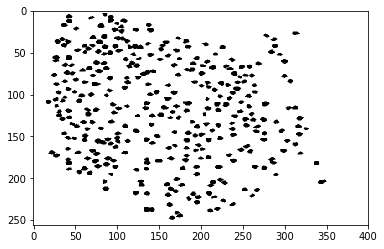

Max value: 255


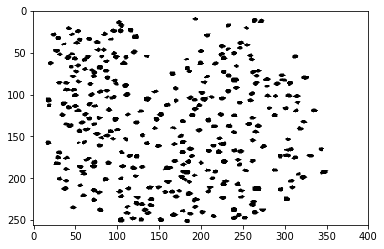

Max value: 1.0


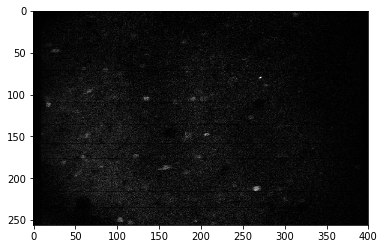

Max value: 0.9450980392156862


In [75]:
vect = cv2.VideoCapture("Databinary/substack500_7fps_03.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()
print('Max value: ' + str(lab_frame.max()))

plt.imshow(y[0][0].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(y[0][0].max()))

plt.imshow(X[0][0].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(X[0][0].max()))

TRAIN

In [197]:
model_stateful_batch1 = load_model(batch_size,true_frag_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (1, 5, 256, 400, 1)       0         
_________________________________________________________________
time_distributed_61 (TimeDis (1, 5, 256, 400, 2)       20        
_________________________________________________________________
time_distributed_62 (TimeDis (1, 5, 128, 200, 2)       0         
_________________________________________________________________
batch_normalization_31 (Batc (1, 5, 128, 200, 2)       8         
_________________________________________________________________
conv_lst_m2d_16 (ConvLSTM2D) (1, 5, 128, 200, 14)      8120      
_________________________________________________________________
batch_normalization_32 (Batc (1, 5, 128, 200, 14)      56        
_________________________________________________________________
time_distributed_63 (TimeDis (1, 5, 128, 200, 2)       254       
__________

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [198]:
gener = Batch_size_1_Generator(frag_len, steps)
valid_generator = Batch_size_1_Generator(frag_len, steps, valid = True)
model_stateful_batch1_trained = train_model(model_stateful_batch1, reps_for_samples, no_frags, gener,valid_generator,epochs, true_frag_len)

Number of training reps 20
Time to reset states
# Iteration 0   loss  0.7154797911643982
0.7154797911643982
# Epoch 1   loss  0.4532855749130249
Done training
Traing loss 0.4532855749130249
Validating
Validating
Remember frag len here is probbaly wrong
1.0 0.00392156862745098
0.5161252 0.50174797
(256, 400)
(256, 400)


IndexError: list index out of range

PREDICT ON TRAINED MODEL

In [145]:
# Predict using just a single sample loaded from file
gener_1 = Batch_size_1_Generator(frag_len, steps)
# this just tests out one sample. I think it is necessary to reset states on prediction too
stateful_preds = batch_prediction(model_stateful_batch1_trained,gener_1, no_frags)

ValueError: Error when checking : expected input_4 to have shape (1, 20, 256, 400, 1) but got array with shape (1, 5, 256, 400, 1)

In [42]:
len(stateful_preds), stateful_preds[0][0].shape

(230, (20, 256, 400, 1))

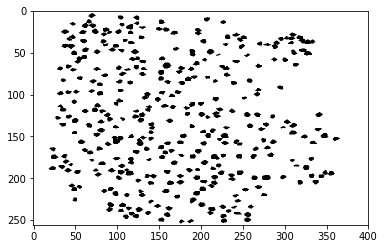

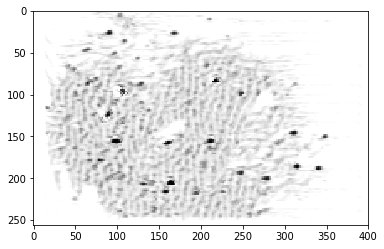

In [48]:
predicted = stateful_preds[229][0].reshape(20,256,400)

vect = cv2.VideoCapture("Databinary/substack500_7fps_02.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()

#predicted result
plt.imshow(predicted[19], cmap = 'gray')
plt.show()

## Mini-batch
## STATEFUL batch_shape = [batch_size, frag_len, x, y, 1]
    8 samples at a time
    update made after no_fragments batches
    y = [8, 1, x, y, 1]

In [98]:
class Batch_size_n_Generator(object):

    def __init__(self, batch_size,frag_len,steps = 1):
        self.frag_len = frag_len
        #print(frag_len)
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idxs = [] 
        self.current_count = 0
        self.data = None
        # dimensions expected by the network
        self.dims = (400,256)
        self.steps = steps
        self.batch_size = batch_size
    
        #self.dup_rows()
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set

    def dup_rows(self, a, indx, num_dups=1):
        return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)
    
    def _resizeNnormalize(self, data, dimso):
        """
        data : the image to be resized 
        dimso : the dimensions to be resized to (tuple)
        """
        data = cv2.resize(data, dimso)
        img = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
        nomalized = img/255
        return nomalized
    
    def _fetchframes(self, indxs, video):
        frames = []
        for indexer in indxs:
            video.set(1,indexer) # Where frame_no is the frame you want
            ret, frame = video.read() # Read the frame
            frames.append(self._resizeNnormalize(frame, self.dims))
        return(frames)
    
    def _fetchlabels(self, label, true_frag_len):
        frames = []
        label.set(1,1)
        ret,lab_frame = label.read()
        label_frame = self._resizeNnormalize(lab_frame, self.dims) 
        y = [label_frame for indx in range(true_frag_len)]
        return(y)
    
    
    def generate(self):
        # this generator returns no_frag fragments for each sample before moving to the next sample
        while True:
           
            if self.current_count == 0:
                self.current_idxs = [np.random.randint(10) for i in range(self.batch_size)]
                print(self.current_idxs)
            
            
            #self.data = [np.load('dummies/video_' + str(ind) + '.npy') for ind in self.current_idxs]
            self.data = [cv2.VideoCapture('Databinary/substack500_7fps_0' + str(ind) + '.avi') for ind in self.current_idxs]
            #video = cv2.VideoCapture('Databinary/substack500_7fps_0' + str(self.current_idx) + '.avi')
            data_len = 120
            # find out number of fragments for data
            no_frags = int((data_len-self.frag_len + 1)/self.steps)
            #no_frags = int(data_len/frag_len)
            
            #print("No frags inside " + str(no_frags))
            self.current_count += 1
            print('current sample number: ' + str(self.current_idxs)+', Fragment ' + str(self.current_count)+ ' of ' + str(no_frags))
            
            if self.current_count == no_frags:
                print(self.current_count)
                self.current_count = 0
            

            # data_range is the range of frames to be fetched for each fragment
            indxs = np.arange(self.current_count*steps,self.current_count*steps+ frag_len, steps)
            x = [self._fetchframes(indxs,video) for video in self.data]
                
 
    
            labels = [(cv2.VideoCapture('Databinary/substack500_7fps_0' + str(ind) + '.label.tif')) for ind in self.current_idxs]
            y = [self._fetchlabels(lebel, len(x[0])) for lebel in labels]
           
                
            y = np.expand_dims(y, axis=-1)
            x = np.expand_dims(x, axis=-1)

           
            #yield x,y
            yield x,y
            

Check that generator is producing the right data

In [81]:
steps = 1
frag_len = 40
true_frag_len = int((frag_len+1)/steps)
batch_size = 4
print('True fragment length ' +str(true_frag_len))
gener_obj = Batch_size_n_Generator(frag_len, batch_size,steps)
gener = gener_obj.generate()
X,y = next(gener)

True fragment length 41
[0, 6, 9, 3]
current sample number: [0, 6, 9, 3], Fragment 1 of 461


In [82]:
X.shape, y.shape

((4, 40, 256, 400, 1), (4, 40, 256, 400, 1))

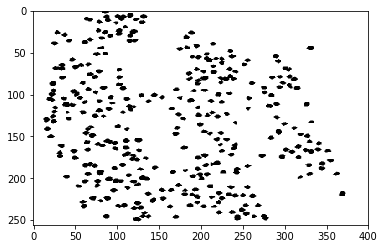

Max value: 255


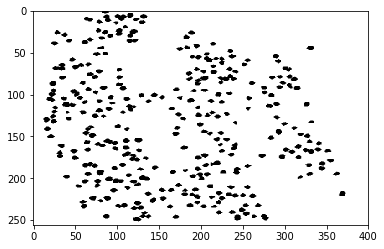

Max value: 1.0


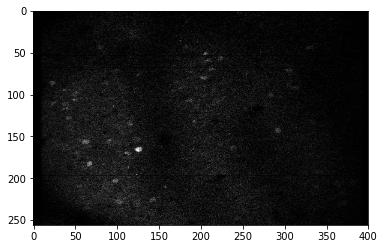

Max value: 0.9058823529411765


In [95]:
vect = cv2.VideoCapture("Databinary/substack500_7fps_00.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()
print('Max value: ' + str(lab_frame.max()))

plt.imshow(y[0][0].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(y[0][0].max()))

plt.imshow(X[0][1].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(X[0][0].max()))

TRAIN ON MODEL

In [150]:
data_len = 50
steps = 2
frag_len = 40
true_frag_len = int((frag_len+1)/steps)
no_frags = int((data_len-frag_len + 1)/steps)
batch_size = 2
no_samples = 4
no_batches = int(no_samples/batch_size)
reps_for_samples = no_batches*no_frags
#no_frags = int(data_len/frag_len)

# this is the number of iterations that result in an epoch. So if we have 10 videos and 
# and batch size is 5, then 2 reps means 1 epoch.
epochs = 2

print(no_frags)
print(true_frag_len)
model_stateful_batchn = load_model(batch_size,true_frag_len)
#model_stateful_batch1 = load_model(frag_len)


5
20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (2, 20, 256, 400, 1)      0         
_________________________________________________________________
time_distributed_45 (TimeDis (2, 20, 256, 400, 2)      20        
_________________________________________________________________
time_distributed_46 (TimeDis (2, 20, 128, 200, 2)      0         
_________________________________________________________________
batch_normalization_23 (Batc (2, 20, 128, 200, 2)      8         
_________________________________________________________________
conv_lst_m2d_12 (ConvLSTM2D) (2, 20, 128, 200, 14)     8120      
_________________________________________________________________
batch_normalization_24 (Batc (2, 20, 128, 200, 14)     56        
_________________________________________________________________
time_distributed_47 (TimeDis (2, 20, 128, 200, 2)      254       
_____

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [122]:
gener = Batch_size_n_Generator(batch_size, frag_len, steps)
valid_generator = Batch_size_n_Generator(batch_size, frag_len, steps)
model_stateful_batchn_trained = train_model(model_stateful_batchn, reps_for_samples, no_frags, gener,valid_generator,epochs, true_frag_len)

Number of training reps 460
Time to reset states
[4, 4, 7, 3]
current sample number: [4, 4, 7, 3], Fragment 1 of 230
# epoch 0   loss  0.19532597064971924
0.781303882598877
current sample number: [4, 4, 7, 3], Fragment 2 of 230
current sample number: [4, 4, 7, 3], Fragment 3 of 230
current sample number: [4, 4, 7, 3], Fragment 4 of 230
current sample number: [4, 4, 7, 3], Fragment 5 of 230
current sample number: [4, 4, 7, 3], Fragment 6 of 230
current sample number: [4, 4, 7, 3], Fragment 7 of 230
current sample number: [4, 4, 7, 3], Fragment 8 of 230
current sample number: [4, 4, 7, 3], Fragment 9 of 230
current sample number: [4, 4, 7, 3], Fragment 10 of 230
current sample number: [4, 4, 7, 3], Fragment 11 of 230
current sample number: [4, 4, 7, 3], Fragment 12 of 230
current sample number: [4, 4, 7, 3], Fragment 13 of 230
current sample number: [4, 4, 7, 3], Fragment 14 of 230
current sample number: [4, 4, 7, 3], Fragment 15 of 230
current sample number: [4, 4, 7, 3], Fragment 16 of

current sample number: [4, 4, 7, 3], Fragment 143 of 230
current sample number: [4, 4, 7, 3], Fragment 144 of 230
current sample number: [4, 4, 7, 3], Fragment 145 of 230
current sample number: [4, 4, 7, 3], Fragment 146 of 230
current sample number: [4, 4, 7, 3], Fragment 147 of 230
current sample number: [4, 4, 7, 3], Fragment 148 of 230
current sample number: [4, 4, 7, 3], Fragment 149 of 230
current sample number: [4, 4, 7, 3], Fragment 150 of 230
current sample number: [4, 4, 7, 3], Fragment 151 of 230
# epoch 150   loss  0.1661154329776764
0.6644617319107056
current sample number: [4, 4, 7, 3], Fragment 152 of 230
current sample number: [4, 4, 7, 3], Fragment 153 of 230
current sample number: [4, 4, 7, 3], Fragment 154 of 230
current sample number: [4, 4, 7, 3], Fragment 155 of 230
current sample number: [4, 4, 7, 3], Fragment 156 of 230
current sample number: [4, 4, 7, 3], Fragment 157 of 230
current sample number: [4, 4, 7, 3], Fragment 158 of 230
current sample number: [4, 4, 

current sample number: [4, 6, 6, 7], Fragment 55 of 230
current sample number: [4, 6, 6, 7], Fragment 56 of 230
current sample number: [4, 6, 6, 7], Fragment 57 of 230
current sample number: [4, 6, 6, 7], Fragment 58 of 230
current sample number: [4, 6, 6, 7], Fragment 59 of 230
current sample number: [4, 6, 6, 7], Fragment 60 of 230
current sample number: [4, 6, 6, 7], Fragment 61 of 230
current sample number: [4, 6, 6, 7], Fragment 62 of 230
current sample number: [4, 6, 6, 7], Fragment 63 of 230
current sample number: [4, 6, 6, 7], Fragment 64 of 230
current sample number: [4, 6, 6, 7], Fragment 65 of 230
current sample number: [4, 6, 6, 7], Fragment 66 of 230
current sample number: [4, 6, 6, 7], Fragment 67 of 230
current sample number: [4, 6, 6, 7], Fragment 68 of 230
current sample number: [4, 6, 6, 7], Fragment 69 of 230
current sample number: [4, 6, 6, 7], Fragment 70 of 230
current sample number: [4, 6, 6, 7], Fragment 71 of 230
# epoch 300   loss  0.15993288159370422
0.639731

current sample number: [4, 6, 6, 7], Fragment 197 of 230
current sample number: [4, 6, 6, 7], Fragment 198 of 230
current sample number: [4, 6, 6, 7], Fragment 199 of 230
current sample number: [4, 6, 6, 7], Fragment 200 of 230
current sample number: [4, 6, 6, 7], Fragment 201 of 230
current sample number: [4, 6, 6, 7], Fragment 202 of 230
current sample number: [4, 6, 6, 7], Fragment 203 of 230
current sample number: [4, 6, 6, 7], Fragment 204 of 230
current sample number: [4, 6, 6, 7], Fragment 205 of 230
current sample number: [4, 6, 6, 7], Fragment 206 of 230
current sample number: [4, 6, 6, 7], Fragment 207 of 230
current sample number: [4, 6, 6, 7], Fragment 208 of 230
current sample number: [4, 6, 6, 7], Fragment 209 of 230
current sample number: [4, 6, 6, 7], Fragment 210 of 230
current sample number: [4, 6, 6, 7], Fragment 211 of 230
current sample number: [4, 6, 6, 7], Fragment 212 of 230
current sample number: [4, 6, 6, 7], Fragment 213 of 230
current sample number: [4, 6, 6

PREDICT ON TRAINED MODEL

In [ ]:
gener_n = Batch_size_n_Generator(batch_size, frag_len, steps).generate()
# this just tests out one sample. I think it is necessary to reset states on prediction too
# Predict using just a single sample loaded from file
stateful_preds = batch_prediction(model_stateful_batchn_trained,gener_n, no_frags)

In [133]:
len(stateful_preds_n), stateful_preds_n[0].shape

(230, (4, 20, 256, 400, 1))

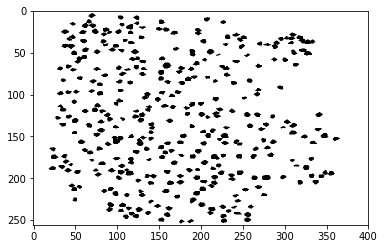

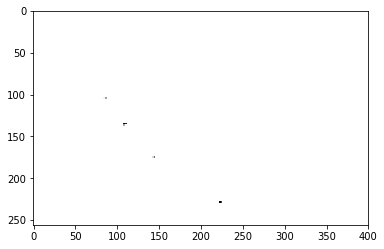

In [146]:
predicted = stateful_preds_n[0][1].reshape(20,256,400)

vect = cv2.VideoCapture("Databinary/substack500_7fps_02.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()

#predicted result
plt.imshow(predicted[19], cmap = 'gray')
plt.show()

ImportError: No module named 'sklearn'